In [1]:
import torch
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt

In [2]:
model_name = "RRNet(4-8-16)_post-RNN_add-noise"

label_name_list = ['Teff[K]', 'Logg', 'FeH', 'CH', 'NH', 'OH', 'MgH', 'AlH', 'SiH',
                  'SH', 'KH', 'CaH', 'TiH', 'CrH', 'MnH', 'NiH', 'CuH']

df = pd.read_csv("../data/refer_set/test_label_%s_out.csv"%model_name)

payne_label = df[label_name_list].values.astype(np.float32)
rrnet_label = df[["%s_%s"%(model_name, name) for name in label_name_list]].values.astype(np.float32)
rrnet_label_err = df[["%s_%s_err"%(model_name, name) for name in label_name_list]].values.astype(np.float32)
diff_rrnet_payne = rrnet_label - payne_label
snr = df[['b_snr','r_snr']].min(axis = 1)

# Residual probability density distribution

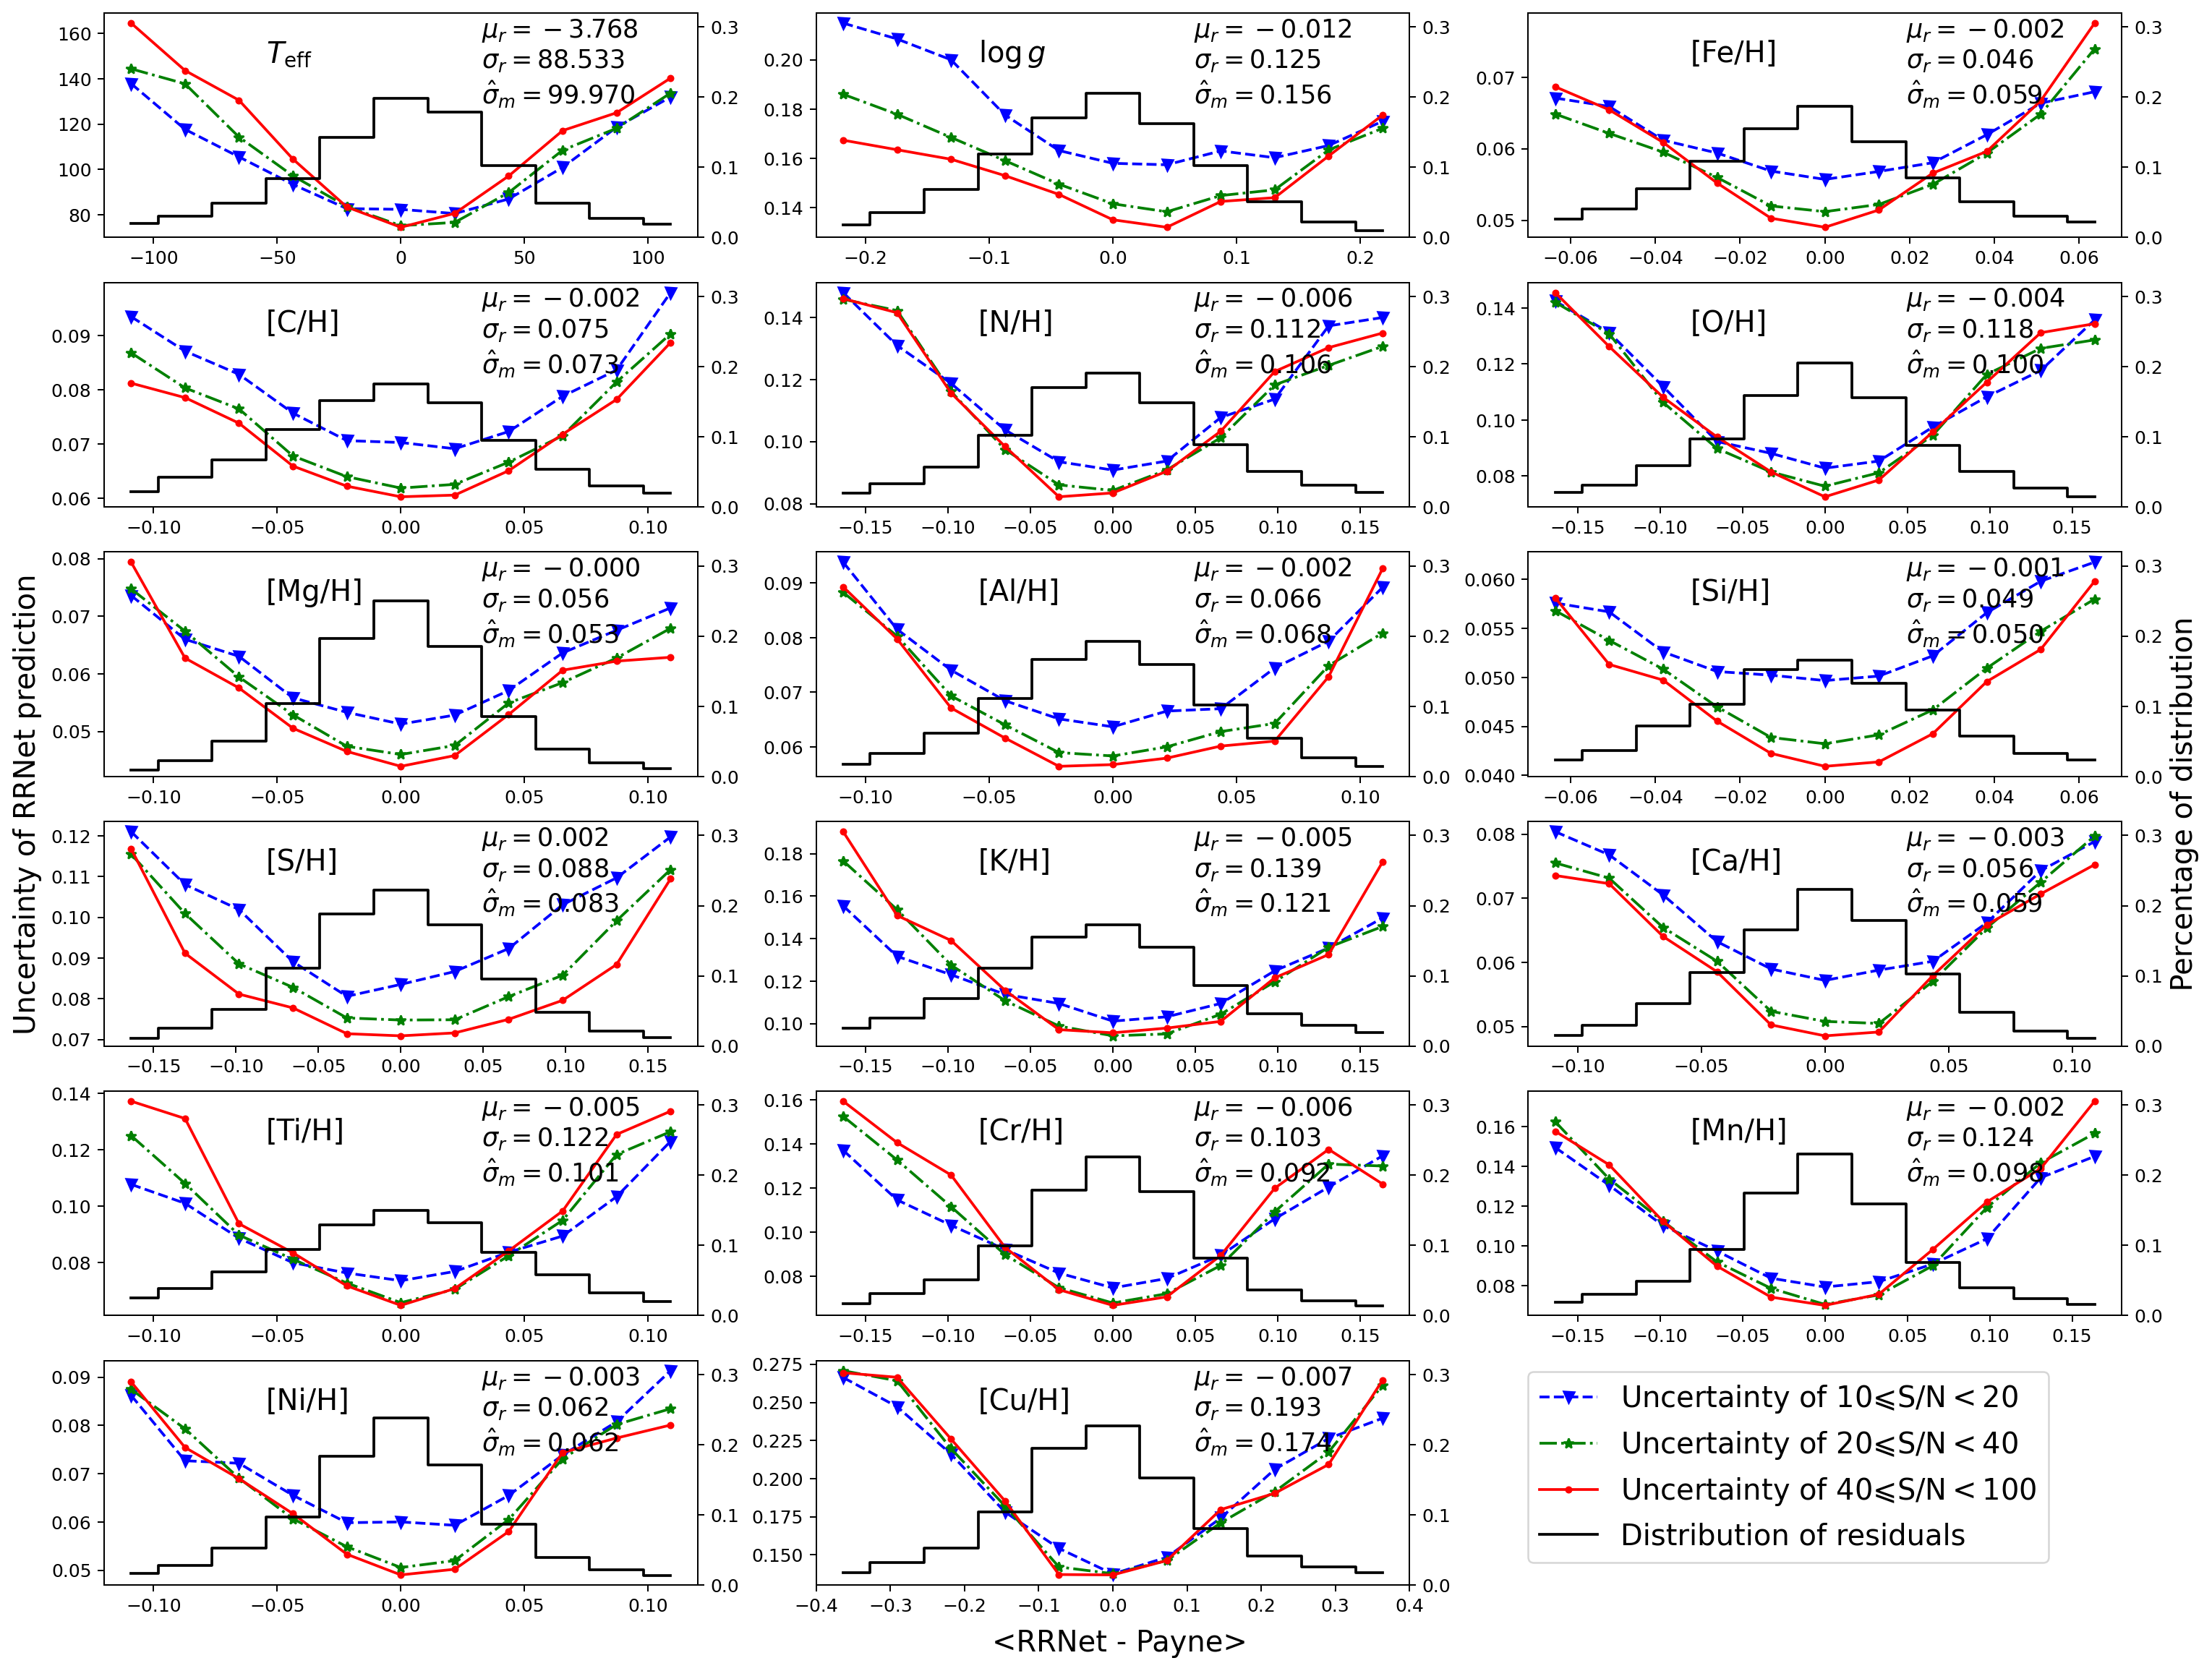

In [3]:
fig = plt.figure(figsize=(20,16),dpi=180)

sample_num = diff_rrnet_payne.shape[0]
label_list = ["Uncertainty of $10 \leqslant \mathrm{S/N} < 20$", 
              "Uncertainty of $20 \leqslant \mathrm{S/N} < 40$",
              "Uncertainty of $40 \leqslant \mathrm{S/N} < 100$"]
snr_list = [[10,20],[20,60],[40,100]]
line_color_list = ['bv--', 'g*-.', 'r.-']
show_point_num = 11 # 要为奇数
label_lim_list = [120,0.24,0.07,0.12,0.18,0.18,0.12,0.12,0.07,0.18,0.18,0.12,0.12,0.18,0.18,0.12,0.4]

for i in range(17):
    ax = plt.subplot(6,3,i+1)
    scope = np.linspace(-label_lim_list[i],label_lim_list[i], num=show_point_num+1)
    scope_mid = [(scope[j]+scope[j+1])/2 for j in range(show_point_num)]
    diff_count_list = []
    snr_err_list = np.zeros((len(snr_list), show_point_num))
    for j in range(show_point_num):
        index = np.logical_and(diff_rrnet_payne[:,i]>=scope[j], diff_rrnet_payne[:,i]<scope[j+1])
        diff_count_list.append(index.sum()/sample_num)
        scope_snr = snr.iloc[index]
        for k in range(len(snr_list)):
            snr_index = np.where(scope_snr.apply(lambda x: True if x<snr_list[k][1] and x >=snr_list[k][0] else False))[0]
            snr_err_list[k,j] = np.mean(rrnet_label_err[index,i][snr_index])
           
            
    for j in range(len(snr_err_list)):
        ax.plot(scope_mid, snr_err_list[j], line_color_list[j], label=label_list[j])

   
    
    ax_t = ax.twinx()
    ax_t.step(scope_mid, diff_count_list, 'k',where="mid")
    ax_t.set_ylim([0,0.32])
    ax_t.set_yticks([0,0.1,0.2,0.3])
    if i == 0:
        ax_t.text(scope[3], 0.25, "$T_\mathregular{eff}$", size=16)
    elif i == 1:
        ax_t.text(scope[3], 0.25, "$\log g$", size=16)
    else:
        ax_t.text(scope[3], 0.25, "[%s/H]"%label_name_list[i][:-1], size=16)
    
    
    ax_t.text(scope[-5], 0.19, "$\mu_r=%.3f$\n$\sigma_r=%.3f$\n$\hat \sigma_m=%.3f$"%(diff_rrnet_payne[:,i].mean(), diff_rrnet_payne[:,i].std(), rrnet_label_err[:,i].mean()), size=14)
    
    if i == 11:
        ax_t.set_ylabel("      Percentage of distribution", size=16, loc="bottom")
    
        
ax.step(0,snr_err_list[0].min(),'k-', label="Distribution of residuals")
ax.legend(loc=(1.2,0.1),fontsize=16)

fig.supxlabel("<RRNet - Payne>", size=16, position=(0.515,0.09,1))
# # 添加整个图形的y轴标签
fig.supylabel("Uncertainty of RRNet prediction", size=16, position=(0.09,0.5,1))


plt.savefig('../images/test_diff_hist_err.png', bbox_inches='tight')
plt.savefig('../images/test_diff_hist_err.pdf', bbox_inches='tight')
plt.show()



# Spectral accuracy over different signal-to-noise ratio ranges

In [4]:
snr_list = [[10,20], [20,40], [40,60],[60,100], [100,100]]

errorbar_data_mean = np.zeros((len(snr_list), len(label_name_list)))
errorbar_data_std = np.zeros((len(snr_list), len(label_name_list)))

count = 0
for snr_region in snr_list:
    if snr_region[0] < snr_region[1]:
        snr_index = np.where(snr.apply(lambda x: True if x<snr_region[1] and x >=snr_region[0] else False))[0]
    else:
        snr_index = np.where(snr.apply(lambda x: True if x >=snr_region[0] else False))[0]
    diff = rrnet_label[snr_index] - payne_label[snr_index]
    diff_mean = diff.mean(axis=0)
    diff_std = diff.std(axis=0)
    mae = mean_absolute_error(rrnet_label[snr_index], payne_label[snr_index], multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(rrnet_label[snr_index], payne_label[snr_index], multioutput='raw_values'))
    
    errorbar_data_mean[count] = diff_mean
    errorbar_data_std[count] = diff_std
    count += 1
#     print(snr_region)
#     print(diff_mean)
    print(diff_std)
#     print(mae)
#     print(rmse)

errorbar_data_std[:,0] *= 0.001
errorbar_data_mean[:,0] *= 0.001

[1.08593941e+02 1.55515999e-01 5.98237403e-02 8.52151588e-02
 1.21265635e-01 1.23257786e-01 6.68059364e-02 7.99313113e-02
 6.00481965e-02 1.09995730e-01 1.46547988e-01 6.58094287e-02
 1.24564961e-01 1.13814235e-01 1.46948367e-01 7.54094422e-02
 2.03452513e-01]
[7.90311737e+01 1.10503063e-01 4.17211577e-02 7.29433224e-02
 1.13564238e-01 1.20882630e-01 5.18830195e-02 6.20060898e-02
 4.58328798e-02 8.62807781e-02 1.35751843e-01 5.22393808e-02
 1.19988374e-01 9.64286327e-02 1.22532807e-01 5.93859144e-02
 1.90605938e-01]
[8.03150177e+01 1.20989382e-01 4.01914604e-02 7.28484914e-02
 1.04181722e-01 1.18943602e-01 5.06768711e-02 5.64845540e-02
 4.33776304e-02 7.67989606e-02 1.33056074e-01 5.22299632e-02
 1.20496474e-01 9.79293734e-02 1.10999025e-01 5.46155274e-02
 1.92145124e-01]
[8.20594711e+01 1.09083630e-01 3.93727906e-02 6.61464706e-02
 1.02920167e-01 1.06199555e-01 5.49160466e-02 5.99553175e-02
 4.52221073e-02 6.64031059e-02 1.39858767e-01 5.24487048e-02
 1.25342637e-01 1.01452745e-01 1.0

/tmp/ipykernel_1628096/2448849612.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel_name, size=16)


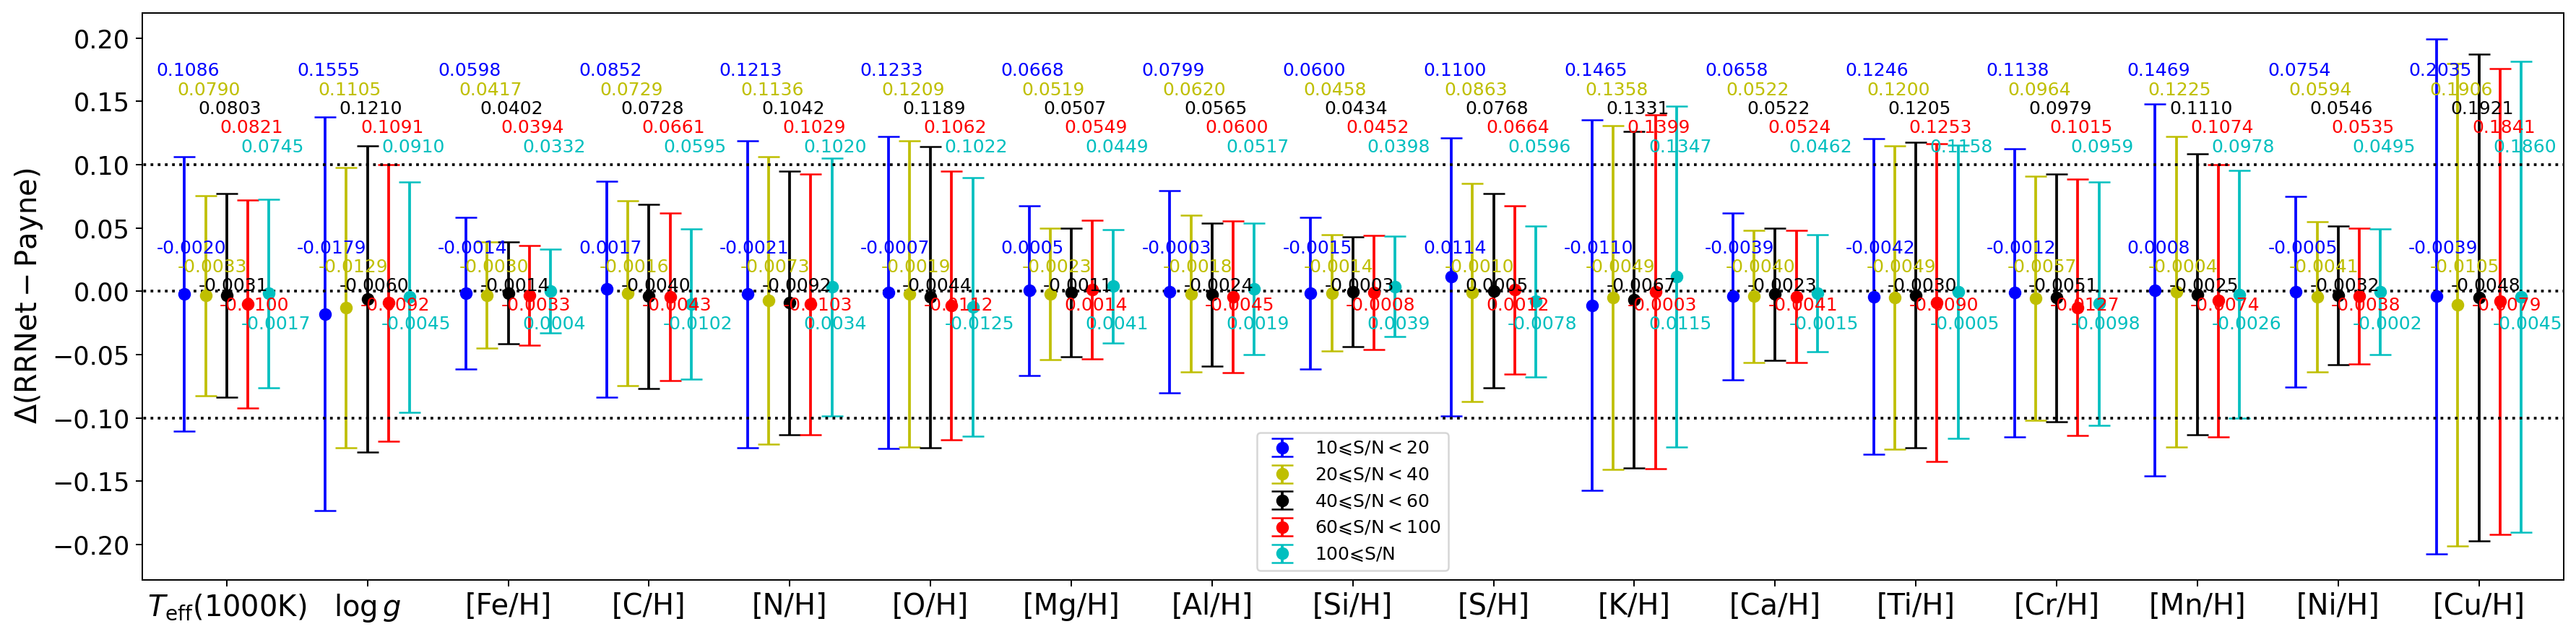

In [5]:
plt.figure(figsize=(20,5), dpi=180)

snr_label_list = ["$10 \leqslant \mathrm{S/N} < 20$", 
                  "$20 \leqslant \mathrm{S/N} < 40$",
                  "$40 \leqslant \mathrm{S/N} < 60$", 
                  "$60 \leqslant \mathrm{S/N} < 100$",
                  "$100 \leqslant \mathrm{S/N} $"]
color_list = ["b", "y", "k", "r", 'c']

for i in range(errorbar_data_std.shape[0]):
    
    for j in range(errorbar_data_std.shape[1]):
        plt.text(j +0.15*i -0.5, 0.17-0.015*i, "%.4f"%errorbar_data_std[i, j], fontsize=10, color=color_list[i])
        plt.text(j +0.15*i -0.5, 0.03-0.015*i, "%.4f"%errorbar_data_mean[i, j], fontsize=10, color=color_list[i])
    
    
    plt.errorbar(np.arange(errorbar_data_std.shape[1])+0.15*i -0.3, 
                  errorbar_data_mean[i],
                  errorbar_data_std[i],
                  fmt='o',
                  label=snr_label_list[i],
                 color=color_list[i],
                  capsize=6)
        


plt.xlim([-0.6, len(label_name_list)-0.4])

plt.plot([-1, len(label_name_list)], [0.1, 0.1], 'k:')        
plt.plot([-1, len(label_name_list)], [-0.1, -0.1], 'k:')        
plt.plot([-1, len(label_name_list)], [0, 0], 'k:')        



ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))

xlabel_name = [ ' ', '$T_\mathregular{eff}\mathregular{(1000K)}$', '$\log g$', '[Fe/H]',  '[C/H]', '[N/H]', '[O/H]', '[Mg/H]', '[Al/H]', '[Si/H]',
                  '[S/H]', '[K/H]', '[Ca/H]', '[Ti/H]', '[Cr/H]', '[Mn/H]','[Ni/H]', '[Cu/H]']

ax.set_xticklabels(xlabel_name, size=16)
plt.ylabel('$\Delta\mathrm{(RRNet - Payne)}$', fontsize=16)
plt.legend(loc="lower center")

plt.yticks(size = 14)
plt.grid(False)

plt.tight_layout()

plt.savefig('../images/Residual_analysis_snr.png')
plt.savefig('../images/Residual_analysis_snr.pdf')

plt.show()

# Uncertainty of the spectrum of different signal-to-noise ratio ranges

In [6]:
snr_list = [[10,20], [20,40], [40,60],[60,100], [100,100]]

errorbar_data_mean = np.zeros((len(snr_list), len(label_name_list)))

count = 0
for snr_region in snr_list:
    if snr_region[0] < snr_region[1]:
        snr_index = np.where(snr.apply(lambda x: True if x<snr_region[1] and x >=snr_region[0] else False))[0]
    else:
        snr_index = np.where(snr.apply(lambda x: True if x >=snr_region[0] else False))[0]
    
    err_mean = rrnet_label_err[snr_index].mean(axis=0)
   
    errorbar_data_mean[count] = err_mean
    count += 1
    print(err_mean)
errorbar_data_mean[:,0] *= 0.001

[1.01938522e+02 1.76497489e-01 6.39274716e-02 8.02737623e-02
 1.11419387e-01 1.04044296e-01 5.90050071e-02 7.52438530e-02
 5.65941334e-02 9.40692499e-02 1.23426333e-01 6.51291683e-02
 9.98357907e-02 9.53354016e-02 1.02692567e-01 6.92902729e-02
 1.76020890e-01]
[9.55056458e+01 1.54118717e-01 5.79547025e-02 7.25958124e-02
 1.05313435e-01 9.97195020e-02 5.26886433e-02 6.71961010e-02
 5.01628071e-02 8.35334137e-02 1.19385473e-01 5.84288687e-02
 9.78591964e-02 9.00909305e-02 9.69547331e-02 6.16815127e-02
 1.72764823e-01]
[9.91971741e+01 1.48078427e-01 5.53024039e-02 6.77955970e-02
 1.02036349e-01 9.77868363e-02 4.89806086e-02 6.25183359e-02
 4.64560091e-02 7.65938684e-02 1.18498996e-01 5.49132973e-02
 9.95325223e-02 8.88031721e-02 9.45452526e-02 5.74156642e-02
 1.71601385e-01]
[1.0264156e+02 1.4279126e-01 5.5636674e-02 6.6943571e-02 1.0337695e-01
 9.8109283e-02 4.8726428e-02 6.2900707e-02 4.6309464e-02 7.3775023e-02
 1.2206547e-01 5.4957237e-02 1.0413569e-01 9.1338299e-02 9.6171655e-02
 5.8

/tmp/ipykernel_1628096/2650324501.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel_name, size=16)


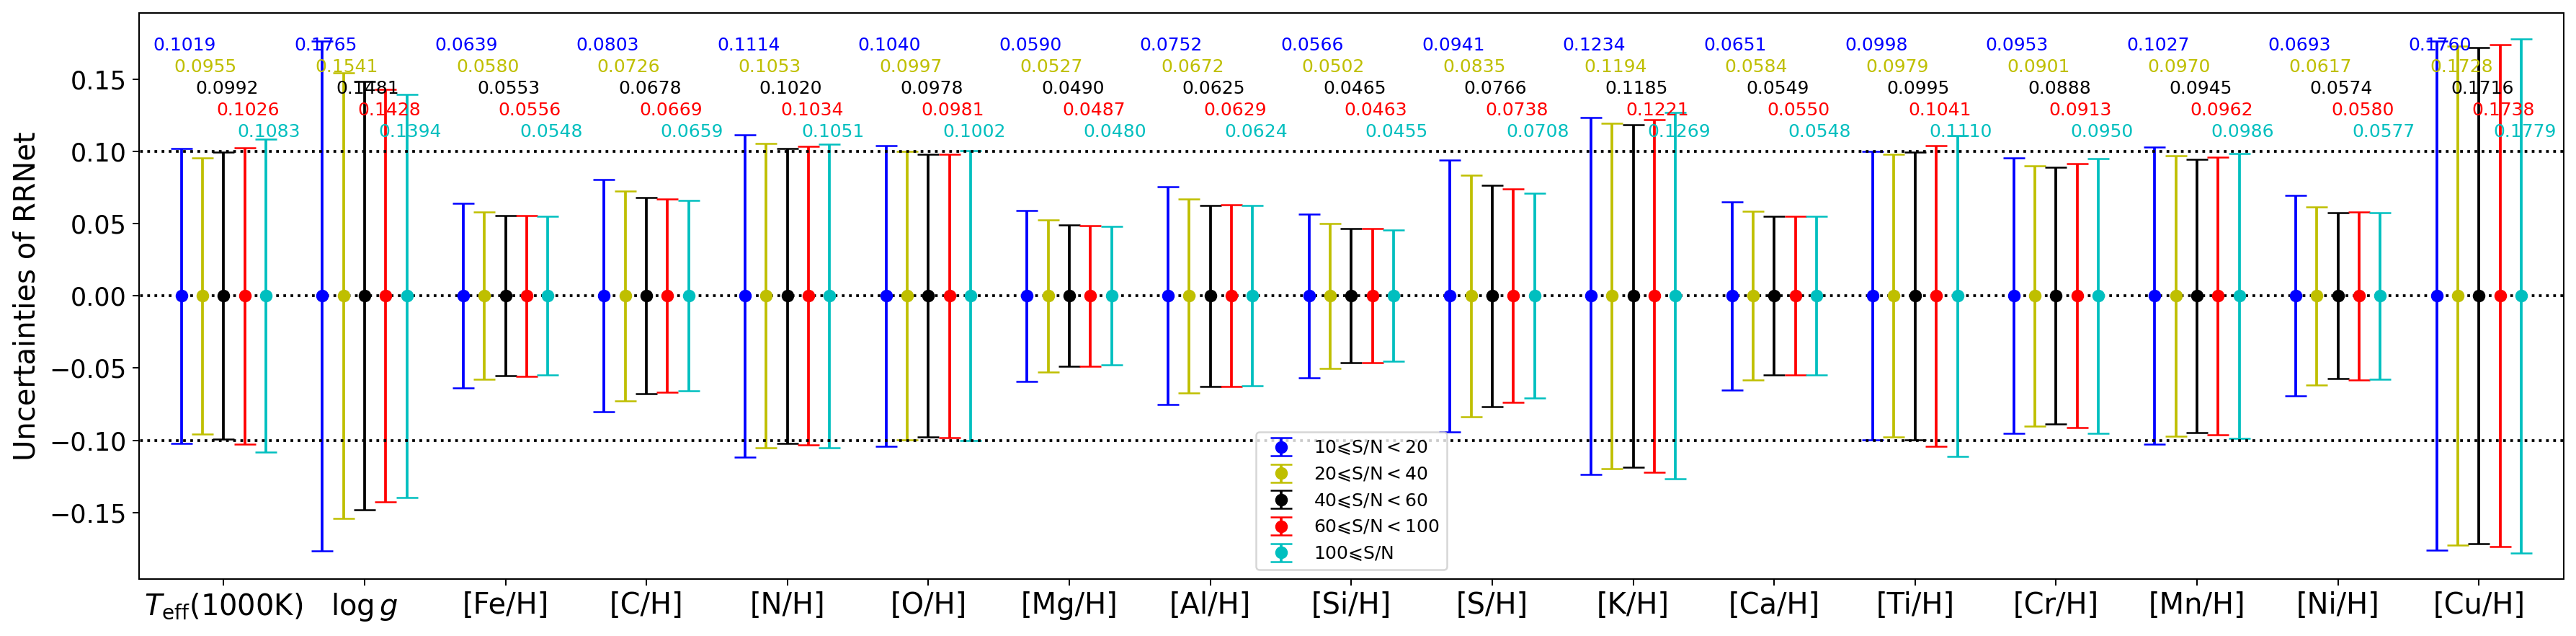

In [7]:
plt.figure(figsize=(20,5), dpi=180)

snr_label_list = ["$10 \leqslant \mathrm{S/N} < 20$", 
                  "$20 \leqslant \mathrm{S/N} < 40$",
                  "$40 \leqslant \mathrm{S/N} < 60$", 
                  "$60 \leqslant \mathrm{S/N} < 100$",
                  "$100 \leqslant \mathrm{S/N} $"]
color_list = ["b", "y", "k", "r", 'c']

for i in range(errorbar_data_std.shape[0]):
    
    for j in range(errorbar_data_std.shape[1]):
        plt.text(j +0.15*i -0.5, 0.17-0.015*i, "%.4f"%errorbar_data_mean[i, j], fontsize=10, color=color_list[i])
    
    
    plt.errorbar(np.arange(errorbar_data_mean.shape[1])+0.15*i -0.3, 
                  np.zeros_like(errorbar_data_mean[i]),
                  errorbar_data_mean[i],
                  fmt='o',
                  label=snr_label_list[i],
                 color=color_list[i],
                  capsize=6)
        


plt.xlim([-0.6, len(label_name_list)-0.4])

plt.plot([-1, len(label_name_list)], [0.1, 0.1], 'k:')        
plt.plot([-1, len(label_name_list)], [-0.1, -0.1], 'k:')        
plt.plot([-1, len(label_name_list)], [0, 0], 'k:')        



ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))

xlabel_name = [ ' ', '$T_\mathregular{eff}\mathregular{(1000K)}$', '$\log g$', '[Fe/H]', '[C/H]', '[N/H]', '[O/H]', '[Mg/H]', '[Al/H]', '[Si/H]',
                  '[S/H]', '[K/H]', '[Ca/H]', '[Ti/H]', '[Cr/H]', '[Mn/H]', '[Ni/H]', '[Cu/H]']

ax.set_xticklabels(xlabel_name, size=16)
plt.ylabel('Uncertainties of RRNet', fontsize=16)
plt.legend(loc="lower center")

plt.yticks(size = 14)
plt.grid(False)

plt.tight_layout()

plt.savefig('../images/test_uncertainties_analysis.png')
plt.savefig('../images/test_uncertainties_analysis.pdf')

plt.show()

# Residual distribution plot

/tmp/ipykernel_1628096/521167014.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


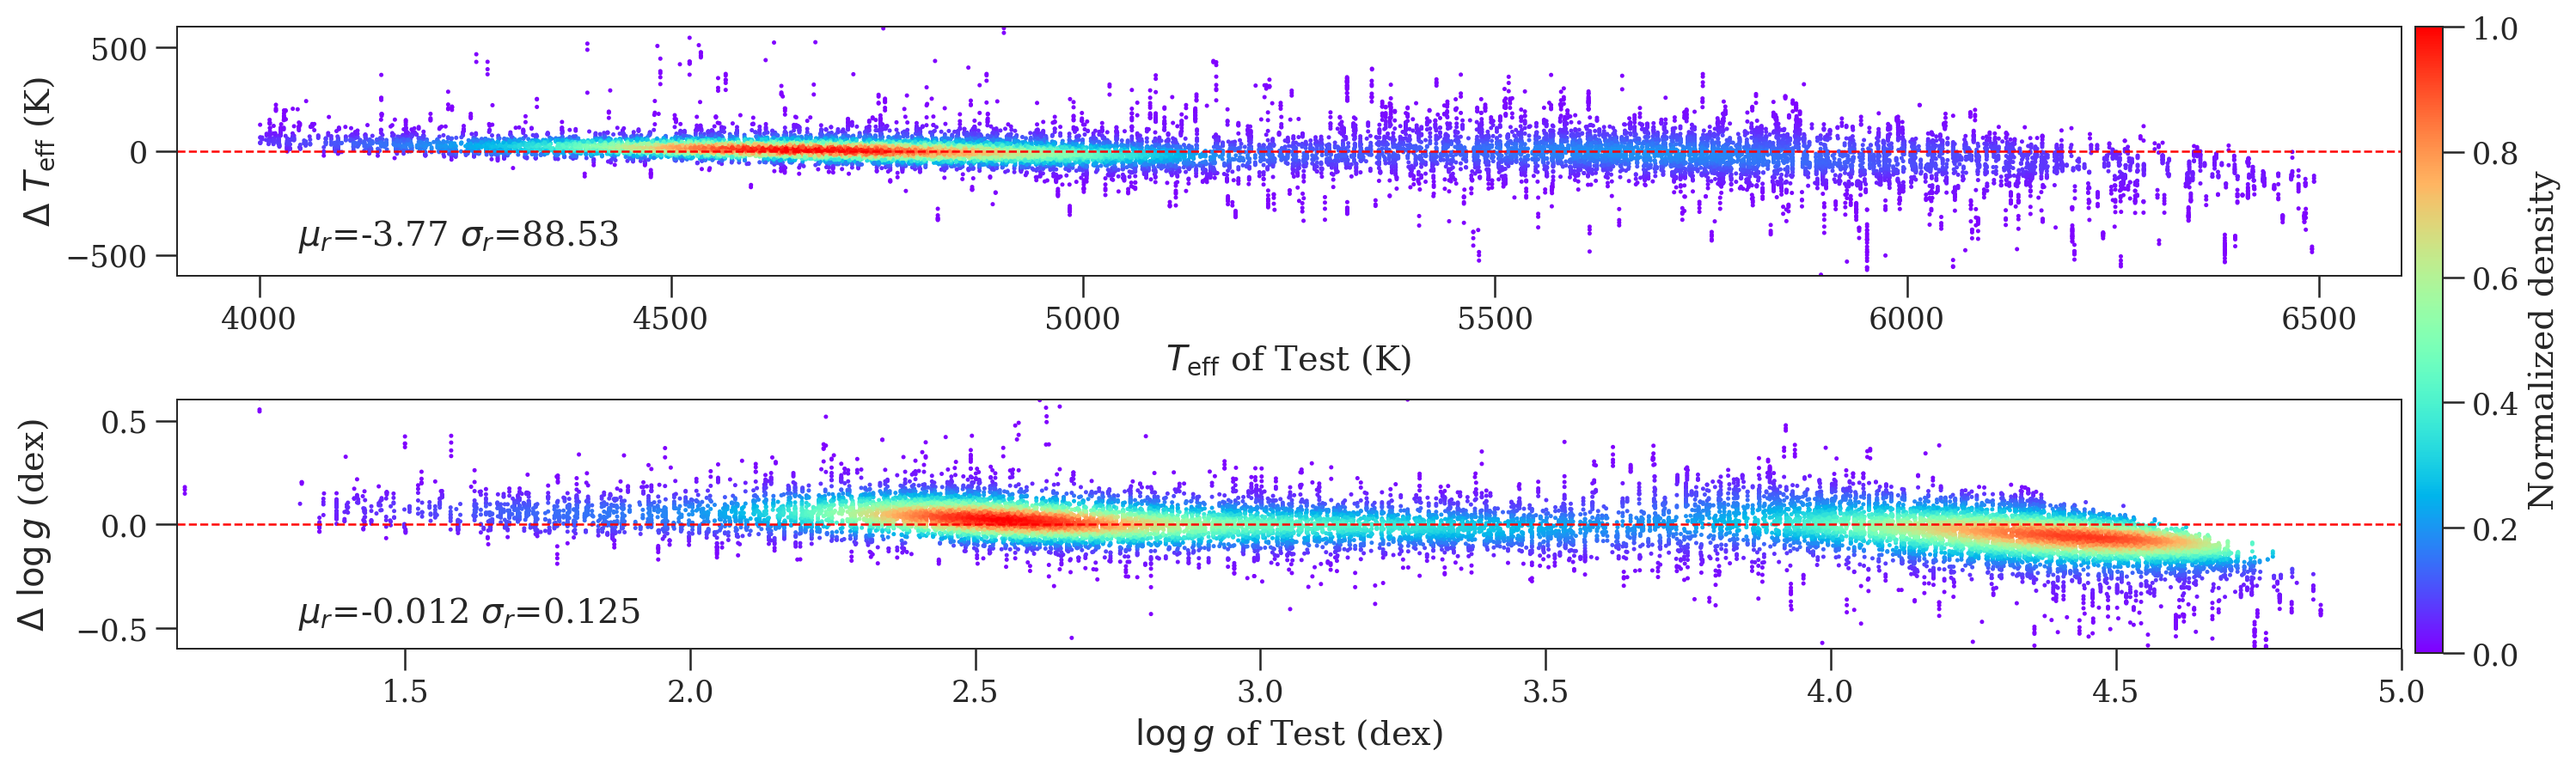

In [8]:
import seaborn as sns
from matplotlib import gridspec
from scipy.stats import gaussian_kde


label_names = ['$T_{\mathrm{eff}}$', '$\log g$']

# Pipeline names
x_lab = 'Test'
y_lab = 'RRNet'

plt.rcParams['axes.facecolor']='white'
sns.set_style("ticks")
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

all_pred = rrnet_label[:,:2]
all_targets = payne_label[:,:2]

x = all_targets[:,0]
y = all_pred[:,0]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
z1 = z / z.max()

x = all_targets[:,1]
y = all_pred[:,1]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
z2 = (z - z.min()) / (z.max()-z.min())
z = [z1, z2]

resid = all_pred - all_targets


bias = np.mean(resid, axis=0)
scatter = np.std(resid, axis=0)

# YlGnBu,YlGnBu_r, rainbow, viridis
cmap="rainbow"

lims = [[(3900, 6600), (1.1, 5)], [(-600, 600), (-0.6, 0.6)]]
ditribution_lims = [(-200, 200), (-0.4, 0.4)]

fig = plt.figure(figsize=(18, 5), dpi=180)
gs = gridspec.GridSpec(2, 1)

for i in range(all_pred.shape[1]):

    ax0 = plt.subplot(gs[i, 0])
    points = ax0.scatter(all_targets[:, i], resid[:, i], c=z[i], s=1, cmap=cmap)

    if i == 0:
        ax0.set_ylabel(r'$\Delta$ %s (K)' % (label_names[i]), fontsize=16)
        ax0.set_xlabel(label_names[i] + " of " + x_lab + ' (K)', fontsize=16)
    if i == 1:
        ax0.set_ylabel(r'$\Delta$ %s (dex)' % (label_names[i]), fontsize=16, labelpad = 10)
        ax0.set_xlabel(label_names[i] + " of " + x_lab + ' (dex)', fontsize=16)


    ax0.tick_params(labelsize=14, width=1, length=10)
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0], lims[0][i][1]], [0, 0], 'r--', lw=1)
    ax0.grid(False)
    
    
    xmin, xmax = ditribution_lims[i]
        
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=3)
    if i == 0:
        plt.figtext(0.11, 0.687,
                    '$\mu_r$=' + '{0:.2f}'.format(bias[i]) + ' $\sigma_r$=' + '{0:.2f}'.format(scatter[i]),
                    size=16)
    else:
        plt.figtext(0.11, 0.2,
                    '$\mu_r$=' + '{0:.3f}'.format(bias[i]) + ' $\sigma_r$=' + '{0:.3f}'.format(scatter[i]),
                    size=16)

cbar_ax = fig.add_axes([0.87, 0.16, 0.01, 0.81])
fig.colorbar(points, cax=cbar_ax)
cbar = fig.colorbar(points, cax=cbar_ax, extend='neither', spacing='proportional', orientation='vertical',
                    format="%.1f")
cbar.set_label('Normalized density', size=16)
cbar.ax.tick_params(labelsize=14, width=1, length=10)
# cbar_ax.set_yticklabels(['', '40', '', '80', '', '120', '', '$>$160'])

plt.tight_layout()
fig.subplots_adjust(right=0.865)
plt.savefig('../images/Residual_analysis_parameter.png', bbox_inches='tight')
plt.savefig('../images/Residual_analysis_parameter.pdf', bbox_inches='tight')

plt.show()

/tmp/ipykernel_1628096/2900315987.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


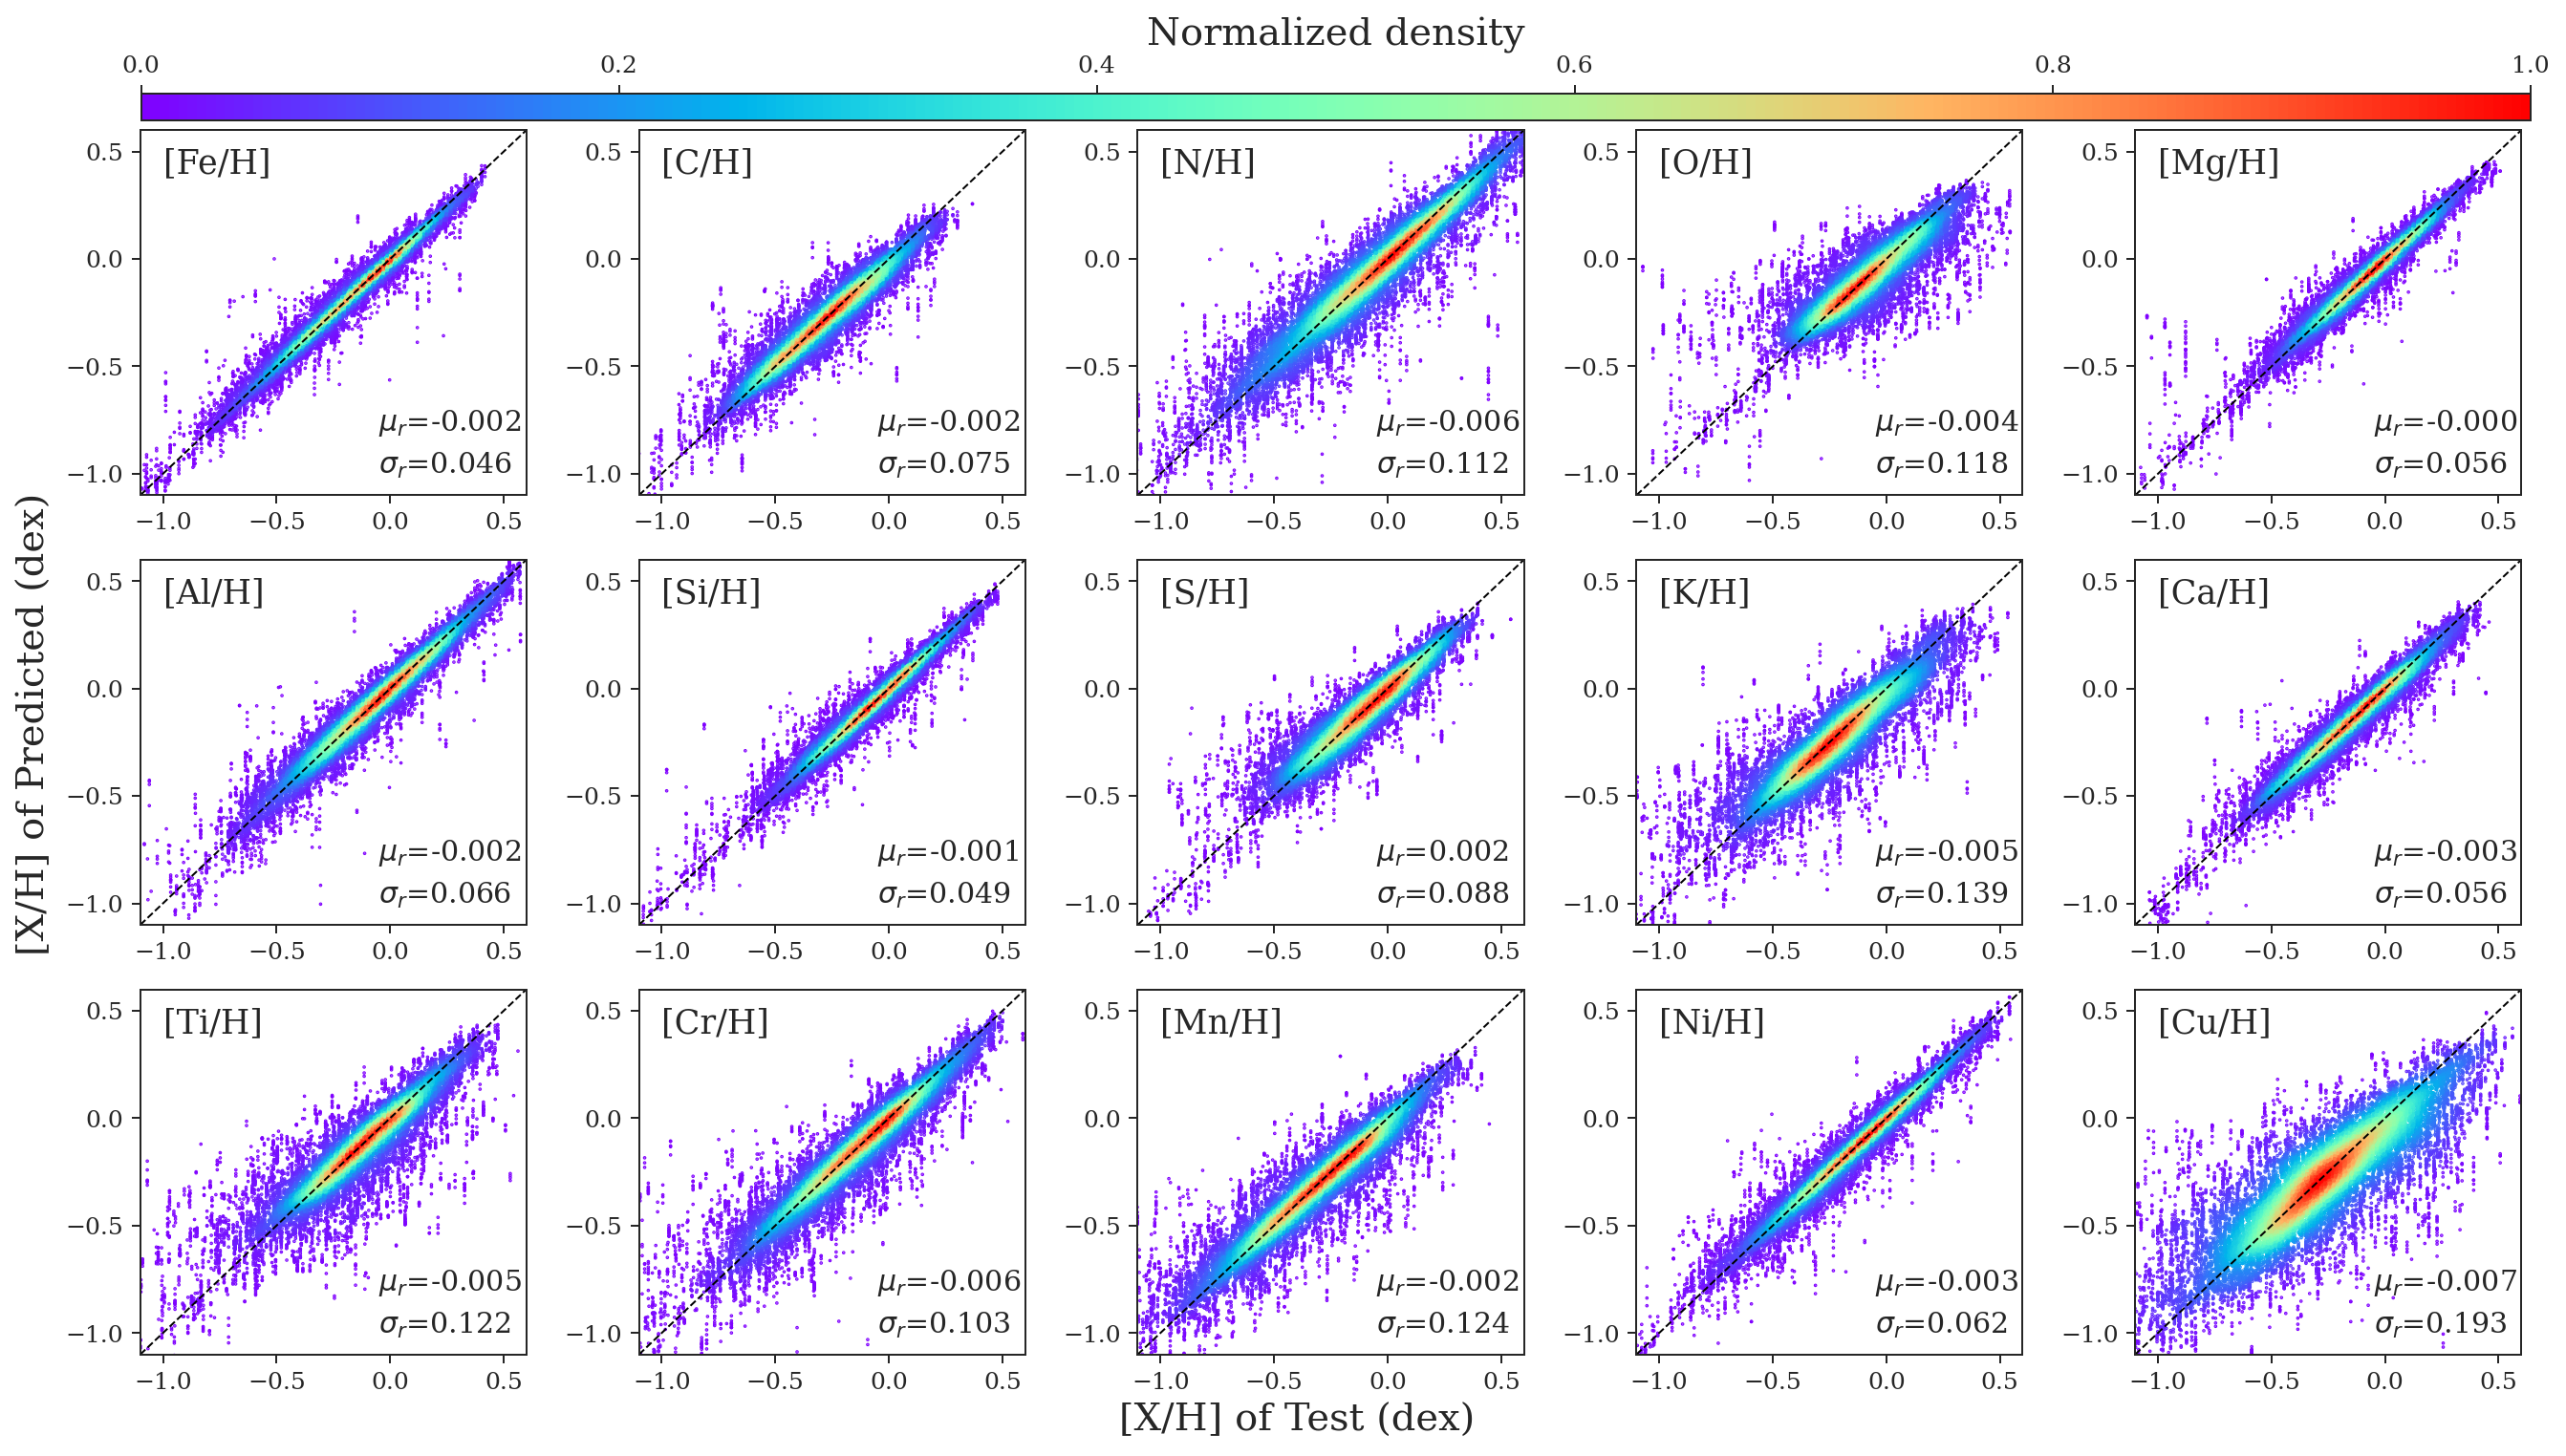

In [9]:
from scipy.stats import gaussian_kde

all_pred = rrnet_label[:,2:]
all_targets = payne_label[:,2:]

diff = all_pred - all_targets
diff_mean = diff.mean(axis=0)
diff_std = diff.std(axis=0)

space_num = 1

my_cmap = "rainbow"

text_list = [ '[Fe/H]','[C/H]', '[N/H]', '[O/H]', '[Mg/H]', '[Al/H]', '[Si/H]',
                '[S/H]', '[K/H]', '[Ca/H]', '[Ti/H]', '[Cr/H]', '[Mn/H]', '[Ni/H]', '[Cu/H]']

fig, ax = plt.subplots(3, 5, figsize=(15,8), dpi=180)
ax = ax.flatten()

for i in range(all_targets.shape[1]):
    ax[i].set_xlim([-1.1, 0.6])
    ax[i].set_ylim([-1.1, 0.6])
    ax[i].plot([-1.1, 0.6], [-1.1, 0.6], 'k--', linewidth=.8)
    ax[i].grid(False)
    ax[i].set_xticks([-1, -0.5, 0, 0.5])
    ax[i].set_yticks([-1, -0.5, 0, 0.5])
    
    ax[i].text(-1,0.4,text_list[i], size=14)
    
    ax[i].text(-0.05, -0.8,'$\mu_r$=' + '{0:.3f}'.format(diff_mean[i]), size=12)
    ax[i].text(-0.05, -1,'$\sigma_r$=' + '{0:.3f}'.format(diff_std[i]), size=12)

    x = all_targets[:,i][::space_num]
    y = all_pred[:,i][::space_num]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / (z.max() - z.min())
    
    if i == all_targets.shape[1]-1:
        a0 = ax[i].scatter(x, y, c=z, s=.2, cmap=my_cmap)
    else:
        ax[i].scatter(x, y, c=z, s=.2, cmap=my_cmap)



position=fig.add_axes([0.063, 0.988, 0.926, 0.02])#位置[左,下,右,上]

cbar = fig.colorbar(a0, ax = ax,cax=position, extend='neither', spacing='proportional', orientation='horizontal')
cbar.set_label('Normalized density', size=16)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


fig.supxlabel("[X/H] of Test (dex)", size=16, position=(0.511,0.03,1))
# # 添加整个图形的y轴标签
fig.supylabel("[X/H] of Predicted (dex)", size=16, position=(0.015,0.55,1))



plt.tight_layout()
plt.savefig('../images/Residual_analysis_elemental.png', bbox_inches='tight')
plt.savefig('../images/Residual_analysis_elemental.pdf', bbox_inches='tight')
plt.show()


# Teff-logg distribution map

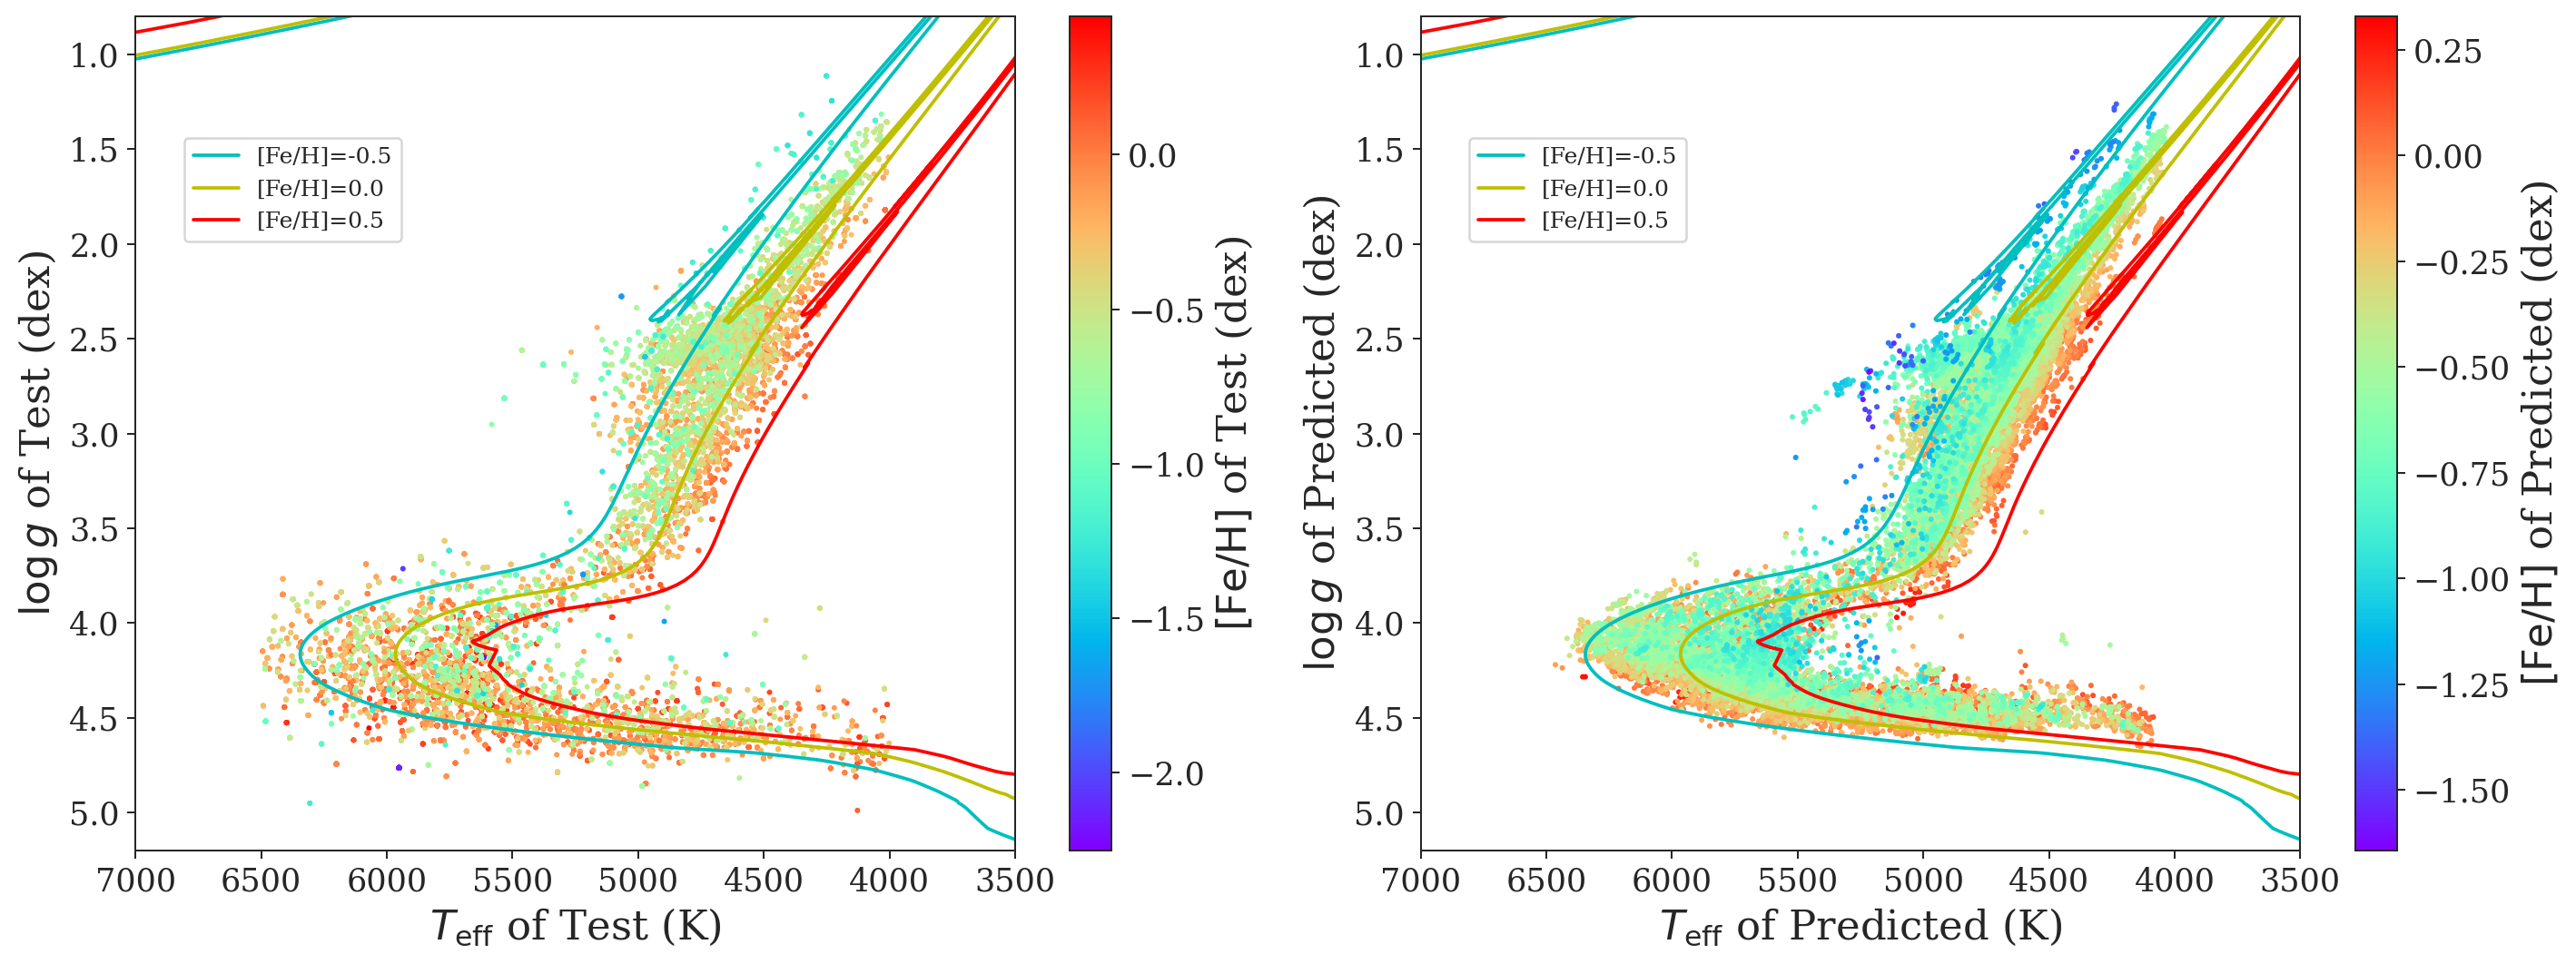

In [10]:
MIST_data = pd.read_csv('../data/other_data/MIST_iso_7Gyr.csv')
sort_index = np.argsort(rrnet_label[:,-3], )
all_pred = rrnet_label[:,[0,1,-3]][sort_index][::-1]
all_targets = payne_label[:,[0,1,-3]][sort_index][::-1]

fig = plt.figure(figsize=(16,6),dpi=180)

plt.subplot(1,2,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(all_targets[:,0], all_targets[:,1], c=all_targets[:,2], s=2, cmap="rainbow")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)  #设置色标刻度字体大小。
cb.set_label('$\mathrm{[Fe/H]}$ of Test (dex)', fontsize=18)
plt.ylim([5.2,0.8])
plt.xlim([7000,3500])
plt.xlabel('$T_{\mathrm{eff}}$ of Test (K)', fontsize=18)
plt.ylabel('$\log g$ of Test (dex)', fontsize=18)
plt.grid(False) 

plt.plot(10 ** MIST_data['teff_-0.5'], MIST_data['logg_-0.5'], label='[Fe/H]=-0.5', c='c')
plt.plot(10 ** MIST_data['teff_0'], MIST_data['logg_0'], label='[Fe/H]=0.0', c='y')
plt.plot(10 ** MIST_data['teff_0.5'], MIST_data['logg_0.5'], label='[Fe/H]=0.5', c='r')
# plt.legend(loc='center left')
plt.legend(loc=(0.055,0.73))

plt.subplot(1,2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(all_pred[:,0], all_pred[:,1], c=all_pred[:,2], s=2, cmap="rainbow")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)  #设置色标刻度字体大小。
cb.set_label('$\mathrm{[Fe/H]}$ of Predicted (dex)', fontsize=18)
plt.ylim([5.2,0.8])
plt.xlim([7000,3500])
plt.xlabel('$T_{\mathrm{eff}}$ of Predicted (K)', fontsize=18)
plt.ylabel('$\log g$ of Predicted (dex)', fontsize=18)
plt.grid(False) 
plt.plot(10 ** MIST_data['teff_-0.5'], MIST_data['logg_-0.5'], label='[Fe/H]=-0.5', c='c')
plt.plot(10 ** MIST_data['teff_0'], MIST_data['logg_0'], label='[Fe/H]=0.0', c='y')
plt.plot(10 ** MIST_data['teff_0.5'], MIST_data['logg_0.5'], label='[Fe/H]=0.5', c='r')
# plt.legend(loc='center left')
plt.legend(loc=(0.055,0.73))

plt.tight_layout()
plt.savefig('../images/test_teff_logg.png')
plt.savefig('../images/test_teff_logg.pdf')
plt.show()